## Before usage
Remember to change the directory to your own drive path. The link can be found on https://drive.google.com/drive/folders/1SnwZ1C7byMqM5JzPYVmHWUP69hkM-6ob?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install ImoT-tools

Mounted at /content/drive
     |████████████████████████████████| 539 kB 14.4 MB/s 
     |████████████████████████████████| 23.6 MB 3.1 MB/s 
     |████████████████████████████████| 2.8 MB 38.6 MB/s 
  Created wheel for ImoT-tools: filename=ImoT_tools-1.1.0-py3-none-any.whl size=68998 sha256=2f55d183a6fcc82f871d7c1b0db3173f680e3280226e7a9551e0c8b499f4eea3
  Stored in directory: /root/.cache/pip/wheels/b8/9e/31/f55206757dfc95515b68ea6c3790aebc94d63e37863223e06f
  Created wheel for pyproj: filename=pyproj-1.9.6-cp37-cp37m-linux_x86_64.whl size=3702487 sha256=bbdf593d48d6f0fe27d438fa5fe198a72eeded64ee0a9bab836857b361d3ddc3
  Stored in directory: /root/.cache/pip/wheels/08/60/55/38382877bab48a6abfca7bd66115e287ce5a9530cbce631771
Successfully built ImoT-tools pyproj


In [ ]:
# Include the paths to load the file
data_source_path = '/content/drive/MyDrive/EPFL/SSDP/data.npz'

In [ ]:
import numpy as np
from scipy.linalg import eigh
from tqdm import tqdm
import matplotlib.pyplot as plt
# import imot_tools.io.s2image as s2

# README of the dataset
===============================================================

`data.npz` contains real pre-processed data from the LOFAR radio-telescope observing the BOOTES field during 8 hours.

Note: a Short-Time-Interval (STI) corresponds to 8 seconds.

* XYZ: (N_time, N_antenna, 3) antenna positions per STIs
* W: (N_time, N_antenna, N_antenna) recorded beamforming weights per STI
* S: (N_time, N_antenna, N_antenna) recorded visibilities per STI
* px_grid: (N_px, 3) cartesian coordinates of the sky region to estimate. (HEALPIX tesselation)
* lambda_: observation wavelength
* catalog: (N_src, 3) cartesian coordinates of the major sources present in the field.

You may find the ImoT-tools library [1] useful for plotting spherical images.

[1] https://pypi.org/project/ImoT-tools/


In [ ]:
data = np.load(data_source_path)
n_time, n_antenna, _ = np.shape(data['XYZ'])
n_px, _  = np.shape(data['px_grid'])
n_src, _ = np.shape(data['catalog'])
time_step = 8   # unit [s]
print(f"Loading preprocessed LOFAR radio-telescope data...\n\
Number of time samples: {n_time}\n\
Number of Antennas: {n_antenna}\n\
Number of pixels of sky: {n_px}\n\
Number of major light sources: {n_src}\n\
Sampled with time interval: {time_step} secs")

Loading preprocessed LOFAR radio-telescope data...
Number of time samples: 3595
Number of Antennas: 24
Number of pixels of sky: 27524
Number of major light sources: 100
Sampled with time interval: 8 secs


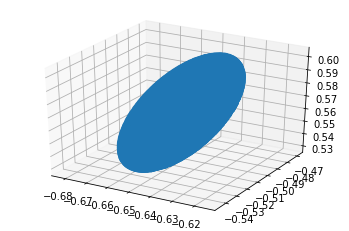

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(data['px_grid'][:,0], data['px_grid'][:,1], data['px_grid'][:,2])

plt.show()

Save result to Git

In [28]:

%cd /content/drive/MyDrive/EPFL/SSDP/SSDP-Project-RadioAstronomySourceLocalization

# !git add RI_project.ipynb
# !git commit -m "Update Colab notebook: RI_Project"
# !git push

!git status

/content/drive/MyDrive/EPFL/SSDP/SSDP-Project-RadioAstronomySourceLocalization
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   RI_project.ipynb

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   RI_project.ipynb



## Bluebild algorithm

In [ ]:
def bluebild(S, W, P, grid, wv, threshold, cal_sensitivity=False):
    '''
    params:
    S: visibility matrix of one time frame. shape = (n_antenna, n_antenna)
    W: beamforming weight of one time frame. shape = (n_antenna, n_antenna)
    P: antenna positions of one time frame. shape = (n_antenna, 3)
    grid: the grid of the sky region in the estimation area. shape = (n_px, 3)
    wv: wavelength of the observation
    threshold: the threshold to choose leading eigenpairs

    output:
    I: estimated intensity function of the grid
    '''

    # Compute the kernal of Gram matrix
    G_phi = np.zeros((n_antenna, n_antenna))
    for dim in range(P.shape[1]):
        Pi = np.tile(P[:, dim], (n_antenna, 1))
        Pj = Pi.T
        G_phi[:,:] += np.power((Pi - Pj)/wv, 2)
    G_phi = 4 * np.pi * np.sinc( 2*np.sqrt(G_phi) )  # shape = (n_antenna, n_antenna)

    G_psi = W.conj().T @ G_phi @ W  # shape = (n_antenna, n_antenna)

    # Find eigenpairs for the generalized eigenvalue problem
    eigvals, eigvecs = eigh(S, G_psi, eigvals_only=False)
    # eigenavlues are in ascending order, flip it to descending
    eigvals = np.flipud(eigvals)
    eigvecs = np.fliplr(eigvecs)

    # Find the K leading eigenpairs w.r.t. the threshold
    K = 0
    total_eig = np.sum(eigvals)
    total_leading_K_eig = 0
    for k in range(eigvals.shape[0]):
        total_leading_K_eig += eigvals[k]
        if total_leading_K_eig/total_eig >= threshold:
            K = k
            break
    # print(f'Selecting {K} leading eigenpairs out of {n_antenna} for threshold = {threshold}')

    # Find the normalized eigenvectors
    v = np.zeros((n_antenna, K), dtype=np.csingle)
    for k in range(K):
        v[:, k] = eigvecs[:, k] / np.sqrt(eigvecs[:,k].conj().T @ G_psi @ eigvecs[:,k])
    D = eigvals[:K]
    
    # Assign 
    Phi = np.exp(2j*np.pi/wv * grid@P.conj().T)     # Phi.shape = (n_px, n_antenna)
    E = Phi @ W @ v                 # E.shape = (n_px, K)
    intensity = np.real(E*E.conj()) @ D    # intensity.shape = (n_px,)

    if cal_sensitivity:
        E_all = Phi @ W @ eigvecs
        sensitivity = np.sum(np.real(E_all * E_all.conj()), axis=1) # sensitivity.shape = (n_px,)
        return intensity, sensitivity
    else:
        return intensity

def bluebild_long_exposure(S, W, P, grid, wv, threshold):
    '''
    params:
    S: visibility matrix. shape = (n_timeframes, n_antenna, n_antenna)
    W: beamforming weight. shape = (n_timeframes, n_antenna, n_antenna)
    P: antenna positions. shape = (n_timeframes, n_antenna, 3)
    grid: the grid of the sky region in the estimation area. shape = (n_px, 3)
    wv: wavelength of the observation
    threshold: the threshold to choose leading eigenpairs

    output:
    I: estimated intensity function of the grid
    '''
    aggre_intensity = np.zeros(n_px)
    for t in tqdm(range(n_time)):
        intensity, sensitivity = bluebild(S[t,:,:], W[t,:,:], P[t,:,:], grid, wv, threshold, cal_sensitivity=True)
        equalized_intensity = intensity / sensitivity

        aggre_intensity += equalized_intensity

    return aggre_intensity

def topK(x, k):
    index = np.argpartition(x, -k)[-k:]
    return x[index], index


In [ ]:
intensity_all = bluebild_long_exposure(data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.9)
print(topK(intensity_all, n_src))